In [1]:
%run init_notebook.py
from settings import GRAPHS_WEB_DIR

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import arviz as az
import os
import yfinance as yf
from statsmodels.regression.linear_model import OLS

In [3]:
import pymc as pm

In [6]:
import arviz
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime

np.random.seed(100)

# VAR

var data 

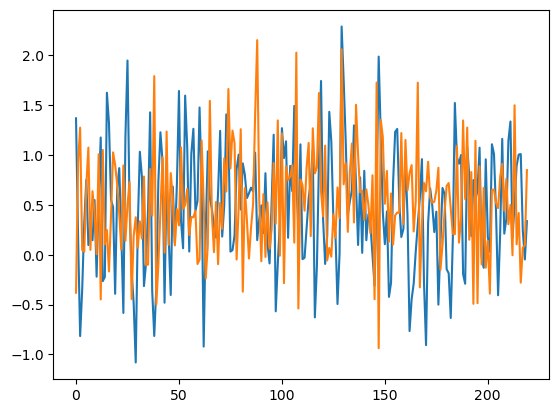

In [7]:
n_lags = 2
n_vars = 2
N = 220
sigma = .5
alpha = np.array(list([.5] * n_vars))

# fake data
A = np.zeros((n_vars, n_lags * n_vars))
for i in range(0, n_vars):
    A[i] = norm(0, .2).rvs((n_lags * n_vars))

arr = np.zeros((N + 20, n_vars))
for i in range(n_lags, N + 20):
    arr[i] = alpha + A @ arr[i - n_lags: i].ravel() + norm(0, sigma).rvs(n_vars)
    
arr = arr[20:]
plt.plot(arr)

# Model

In [8]:
coords = {
    'n_lags': [*range(0, n_lags)],
    'n_vars': [*range(0, n_vars)],
    'n_var_lags': [*range(0, n_lags*n_vars)],
    'time': [*range(n_lags, N)],
}

In [96]:
with pm.Model(coords=coords) as VAR:
    Theta = pm.Normal('Theta', mu=0, sigma=1, dims=('n_vars', 'n_var_lags'))
    # sigma = pm.HalfNormal('sigma', 1, dims=('n_vars',))
    alpha = pm.Normal('alpha', mu=0, sigma=1, dims=('n_vars',))

    sd_dist = pm.Exponential.dist(1.0, size=len(coords['n_vars']))
    packed_chol = pm.LKJCholeskyCov('sigma_chol', eta=1, n=len(coords['n_vars']), sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(n=len(coords['n_vars']), packed=packed_chol, lower=True)

    mu = alpha + get_VAR(Theta, arr, len(coords['n_lags']), len(coords['n_vars']))

    # likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=arr[n_lags:], dims=('time', 'n_vars',))
    vals = pm.MvNormal('vals', mu=np.zeros(len(coords['n_vars'])), chol=chol, dims=('time', 'n_vars',), observed=arr[n_lags:])

    idata = pm.sample() #(draws=100, chains=1)


KeyboardInterrupt



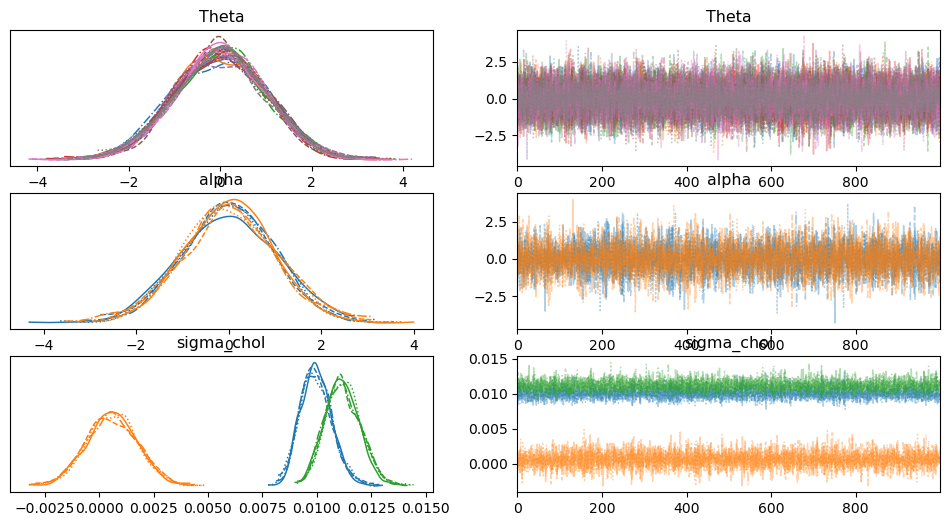

In [182]:
az.plot_trace(idata);

## plot posterior outcome

In [ ]:
arr_lagged = get_arr_lagged(arr, n_lags)
samples = [
    [
        idata.posterior.Theta[np.random.randint(0, len(idata.sample_stats.chain)), z].values @ arr_lagged[i] 
        for i in range(arr_lagged.shape[0])
    ]
    for z in np.random.randint(0, len(idata.sample_stats.draw), 100)
]

samples = np.array(samples)

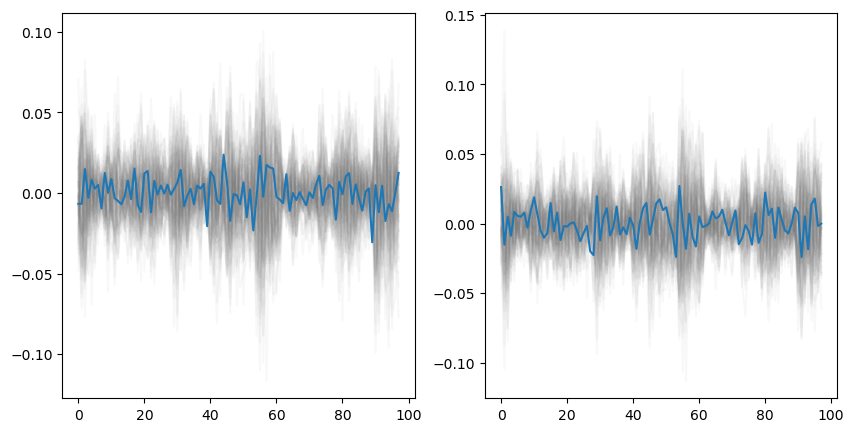

In [186]:
cols = 2
rows = int(np.ceil(n_vars / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5 * rows))
for idx, ax in enumerate(axes.ravel()):
    ax.plot(samples[:, :, idx].transpose(), color='grey', alpha=.05);
    ax.plot(arr[n_lags:, idx])